# Experiment 6b Trials

In [1]:
import numpy as np
import random
import datetime
import pandas as pd
import json
from itertools import product
from markdown import markdown
import textwrap
import copy

from msdm.domains import GridWorld
from msdm.algorithms import PolicyIteration
from vgc_project import gridutils, sampsat

# Experiment Parameters

In [2]:
EXPERIMENT_CODE_VERSION = "6b"
EXPERIMENT_DESCRIPTION = """
Grids 12-15 breadcrumbs yoked to exp 3.
"""
EXPECTED_TIME = "15 minutes"

### Instructions and training

In [3]:
default_trialparams = dict(
    breadCrumbs=[
        {'x': 1, 'y': 0},
        {'x': 2, 'y': 2},
        {'x': 3, 'y': 4},
        {'x': 2, 'y': 8},
        {'x': 3, 'y': 8},
    ],
    participantStarts=True,
    CRUMB_SIZE=.05,
    MAX_TIMESTEPS=int(1e10),
    GOALSIZE=.4,
    TILE_SIZE=50,
    OBJECT_ANIMATION_TIME=50
)

def create_GridNavBreadcrumbs_trial(
    *,
    tile_array,
    default_trialparams,
    default_taskparams,
    traj=None,
    crumb_distance=2,
    rng=random
):
    gw = GridWorld(
        tile_array,
        absorbing_features=('G', ),
        initial_features=('S'),
        wall_features="#0123456789"
    )
    goalstate = gw.absorbing_states[0]
    initstate = gw.initial_states[0]
    if traj is None:
        traj = PolicyIteration().plan_on(gw).policy.run_on(mdp=gw, rng=rng).state_traj
    else:
        traj = copy.deepcopy(traj)
    traj = list(traj)
    while (traj[0]['x'] == initstate['x']) and (traj[0]['y'] == initstate['y']):
        traj.pop(0)
    breadCrumbs = []
    while traj:
        s = traj.pop(0)
        if (len(breadCrumbs) > 0) and (breadCrumbs[-1] == s):
            continue
        breadCrumbs.append({**s})
        if traj:
            traj.pop(0)
    breadCrumbs.append({**goalstate})
    return dict(
        type='GridNavBreadcrumbs',
        trialparams={
            **default_trialparams,
            'breadCrumbs': breadCrumbs
        },
        taskparams={
            **default_taskparams,
            "feature_array": tile_array,
            "init_state": [gw.initial_states[0]['x'], gw.initial_states[0]['y']],
            "absorbing_states":[[s['x'], s['y']] for s in gw.absorbing_states],
        }
    )

In [4]:
def generate_instructions(
    *,
    default_trialparams,
    default_taskparams,
    nRounds,
    roundBonusCents,
    probetype,
    rng=random
):
    practice_grids = [
        [
            'G............',
            '.............',
            '.............',
            '......#......',
            '......#......',
            '......#...0..',
            '.11#######000',
            '.1....#......',
            '.1....#......',
            '......#......',
            '.............',
            '.............',
            '............S'
        ],
        [
            '............G',
            '.............',
            '.............',
            '......#......',
            '......#......',
            '......#......',
            '.11#######...',
            '.1....#......',
            '.1....#......',
            '......#......',
            '......0......',
            '.....00......',
            'S.....0......'
        ]
    ]
    practice_trials = []
    for i, g in enumerate(practice_grids):
        practice_trials.append(create_GridNavBreadcrumbs_trial(
            tile_array=g,
            default_trialparams={
                **default_trialparams,
                "roundBonusCents": 0.0,
                "grid": f"practice-{i}",
                "roundtype": "practice",
                "message": "Catch the black dots"
            },
            default_taskparams=default_taskparams,
            traj=None,
            crumb_distance=2,
            rng=rng
        ))
        
    pretask = [
        {"type": "reCAPTCHA"},
        {
            "type": "fullscreen",
            "fullscreen_mode": True
        },
        {
            "type": "CustomInstructions",
            "instructions": markdown(textwrap.dedent("""
                # Instructions
                Thank you for participating in our experiment!

                You will play a game where you control a blue circle on a grid. You can move up, down, left, or right by pressing the __arrow keys__⬆️⬇️⬅️➡️.

                <img src="static/images/bluedotgrid.png" width="150px">

                Your goal is to catch the <b><u>black dots</b></u> that appear as you move.
                
                <br>
                The black dots eventually lead to a <span style='background-color: yellow;'><b>Yellow</b></span> 
                tile with a <span style="color: green"><b>green</b></span> square.

                <img src="static/images/goalsquare.png" width="150px">

                The green square will shrink when you stand still. It will initially shrink slowly,
                and then shrink quickly once you start moving. You must catch the black dots before
                the square shrinks too much.
                
                <br>

                __Black tiles__ are walls that you cannot pass through ⛔️.

                <br>

                <span style="background-color: cornflowerblue;color:white"><b>Blue</b></span>
                tiles are obstacles that might change between different rounds.
                You cannot pass through these either 🚫.
                <br>
                Thank you for participating in our experiment!
            """)),
            "timing_post_trial": 1000,
            "continue_wait_time": 5000,
        },
        *practice_trials,
    ]
    if probetype == "attention":
        pretask.append(
            dict(
                type="CustomSurvey",
                preamble=markdown(textwrap.dedent(f"""
                    # Instructions
                    Next, we will give you a series of {nRounds} rounds. For each round, you will receive a
                    bonus of {roundBonusCents} cents but <b>only if you catch all the black dots</b>.

                    You can win a total bonus of up to &#36;{nRounds*roundBonusCents/100:.2f}.

                    <br>

                    At the start of each round, we will show you a grid showing only the walls (black).
                    When you are ready to begin the round, press the __spacebar__.
                    The obstacles (<span style="background-color: cornflowerblue; color:white">blue</span>),
                    your start location, and goal will appear.

                    ## ☝️ Please note the following

                    To transition between the rounds as smoothly as possible, we recommend using
                    one hand to press the spacebar and the other use the arrow keys 🙌.

                    <br>

                    Try to go as <u>quickly</u> and <u>carefully</u> as possible 💫.

                    In addition, we are interested in your thought process while navigating each maze 🤔.
                    Following each trial, we will ask you <u>how aware of each obstacle you were at any point</u>.
                    Your answer should reflect the amount you paid attention to an obstacle, whether it was
                    at the beginning or end of navigating the maze. **Your answers to the awareness questions will not affect your bonus**.

                    <br>
                    <hr>
                    To continue, you must answer the following comprehension questions correctly within 2 tries.
                    """)),
                maxAttempts=2,
                questions=[
                    {
                      "prompt": "When will you receive a bonus?", 
                      "options": ["If the black dots are avoided", "If the black dots are all collected", "There is no bonus"], 
                      "required": True, 
                      "requireCorrect": True,
                      "correct": "If the black dots are all collected",
                      "name": "blackdotCheck",
                      "type": "multiple-choice"
                    },
                    {
                      "prompt": "Your answers to the awareness questions will affect your bonus.", 
                      "options": ["Always", "Sometimes", "Never"], 
                      "required": True, 
                      "requireCorrect": True,
                      "correct": "Never",
                      "name": "probeNoBonusCheck",
                      "type": "multiple-choice"
                    }
                ]
            )
        )
    elif probetype == "memory":
        pretask.append(
            dict(
                type="CustomSurvey",
                preamble=markdown(textwrap.dedent(f"""
                    # Instructions
                    Next, we will give you a series of {nRounds} rounds. For each round, you will receive a
                    bonus of {roundBonusCents} cents but <b>only if you catch all the black dots</b>.

                    You can win a total bonus of up to &#36;{nRounds*roundBonusCents/100:.2f}.

                    <br>

                    At the start of each round, we will show you a grid showing only the walls (black).
                    When you are ready to begin the round, press the __spacebar__.
                    The obstacles (<span style="background-color: cornflowerblue; color:white">blue</span>),
                    your start location, and goal will appear.

                    ## ☝️ Please note the following

                    To transition between the rounds as smoothly as possible, we recommend using
                    one hand to press the spacebar and the other use the arrow keys 🙌.

                    <br>

                    Try to go as <u>quickly</u> and <u>carefully</u> as possible 💫.

                    Following each trial, we will ask you about where one of the obstacles was originally placed.
                    You will be shown two possible locations, and asked where it was in the maze you just did. 
                    **Your answers to these questions will not affect your bonus.**.

                    <br>
                    <hr>
                    To continue, you must answer the following comprehension questions correctly within 2 tries.
                    """)),
                maxAttempts=2,
                questions=[
                    {
                      "prompt": "When will you receive a bonus?", 
                      "options": ["If the black dots are avoided", "If the black dots are all collected", "There is no bonus"], 
                      "required": True, 
                      "requireCorrect": True,
                      "correct": "If the black dots are all collected",
                      "name": "blackdotCheck",
                      "type": "multiple-choice"
                    },
                    {
                      "prompt": "Your answers to the location questions will affect your bonus.", 
                      "options": ["Always", "Sometimes", "Never"], 
                      "required": True, 
                      "requireCorrect": True,
                      "correct": "Never",
                      "name": "probeNoBonusCheck",
                      "type": "multiple-choice"
                    }
                ]
            )
        )
    else:
        raise Exception("unknown probetype")
        
    return pretask

In [5]:
def generate_posttask():
    return [
        {
            "type": 'CustomSurvey',
            "questions": [
              {
                "prompt": "Have you participated in an experiment with a game nearly identical to this one except it did not involve collecting black dots?", 
                "required": True,
                "options": ["Yes", "No"], 
                "name": "playedGame",
                "type": "multiple-choice"
              },
              {
                "prompt": "Gender", 
                "required": True,
                "rows": 1,
                "columns": 50,
                "name": "gender",
                "type": "textbox"
              },
              {
                "prompt": "Age", 
                "required": True,
                "rows": 1,
                "columns": 50,
                "name": "age",
                "type": "textbox"
              }
            ],
        },
        {
            "type": "SaveGlobalStore"
        },
        {
            "type": "fullscreen",
            "fullscreen_mode": False
        },
    ]

### Get responses from experiment 3 to be yoked

In [6]:
exp3_mod_grids = json.load(open("../mazes/mazes_12-15_mod.json", 'r'))
EXP3_NAV_FILE = "../exp3/data/navtrials.json"
EXP3_ALL_NAV_FILE = "../exp3/data/all-navtrials.json"
exp3_filt_nt = pd.read_json(open(EXP3_NAV_FILE, 'r'))
exp3_all_nt = pd.read_json(open(EXP3_ALL_NAV_FILE, 'r'))

In [7]:
nonexcluded = exp3_filt_nt.sessionId.unique()
exp3_nt = exp3_all_nt[exp3_all_nt['sessionId'].isin(nonexcluded)]
assert all(exp3_nt.groupby(["sessionId", 'round'])['reward'].sum().groupby("sessionId").count() == 8)

In [8]:
EXP3_ALL_ATTN_FILE = "../exp3/data/all-attentiontrials.json"
EXP3_ALL_MEM_FILE = "../exp3/data/all-memorytrials.json"
exp3_at = pd.read_json(open(EXP3_ALL_ATTN_FILE, 'r'))
exp3_mt = pd.read_json(open(EXP3_ALL_MEM_FILE, 'r'))

In [9]:
exp3_participantround_probes = pd.concat([
    exp3_at.groupby(['sessionId', 'round']).apply(
        lambda rs: rs.sort_values('queryround').to_dict('records')
    ),
    exp3_mt.groupby(['sessionId', 'round']).apply(
        lambda rs: rs.sort_values('queryround').to_dict('records')
    )
])
memory_participants = exp3_mt.sessionId.unique()
attn_participants = exp3_at.sessionId.unique()

In [10]:
exp3_resp = [] #each participant's grids and probes, in order
for pid, prows in exp3_nt.groupby("sessionId"):
    resp = {'sessionId': pid, 'rounds': []}
    for r, rrows in prows.sort_values("round").groupby("round"):
        traj = [{'x': x, 'y': y} for x, y in rrows.sort_values("trialnum").trans_state]
        assert rrows.sort_values("trialnum").iloc[0].state_type == "S"
        assert rrows.sort_values("trialnum").iloc[-1].nextstate_type == "G"
        original_probedata = exp3_participantround_probes[(pid, r)]
        probeparams = []
        for pdata in original_probedata:
            assert pdata['sessionId'] == pid
            assert pdata['navgridname'] == rrows.iloc[0]['gridname']
            assert pdata['round'] == r
            if pid in memory_participants:
                new_pdata = {
                    k: pdata[k] for k in ['probegridname_mem', 'navgridname', 'probeobs', 'queryround', 'true_color']
                }
                new_pdata['probetype'] = "memory"
            elif pid in attn_participants:
                new_pdata = {
                    k: pdata[k] for k in 
                    ['probeobs', 'queryround', 'navgridname']
                }
                new_pdata['probetype'] = "attention"
            else:
                raise ValueError("unrecognized participant")
            probeparams.append(new_pdata)
        round_params = {
            "navparams": {
                "sessionId": pid,
                "round": r,
                "gridname": rrows.iloc[0]['gridname'],
                "traj": traj
            },
            "probeparams": probeparams
        }
        resp['rounds'].append(round_params)
    exp3_resp.append(resp)

In [11]:
def create_attention_probe_configs(*, grid_round, grid, transform, navtrial_taskparams, probeparams):
    configs = []
    for pp in probeparams:
        obs = str(pp['probeobs'])
        probegridparams = copy.deepcopy(navtrial_taskparams)
        probegridparams["feature_colors"][obs] = '#48D1CC' #MediumTurquoise
        assert pp['probetype'] == 'attention'
        configs.append({
            "type": "GridBlockAttentionQuery",
            "roundtype": "attentionquery",
            "round": grid_round,
            "grid": grid,
            "trans": transform,
            "queryround": pp['queryround'], #the n-th asked about this round
            "probegridparams": probegridparams,
            "probeobs": obs,
            "questiontext": "How aware of the highlighted obstacle were you at any point?"
        })
    return configs

In [12]:
def create_memory_probe_configs(*, mod_grids, grid_round, grid, transform, navtrial_taskparams, probeparams):
    GREEN = '#44A9A0'
    YELLOW = "#DCCB5D"
    configs = []
    for pp in probeparams:
        obs = str(pp['probeobs'])
        mod_obs = dict(zip("0123456", "ABCDEFG"))[obs]
        probegridparams = copy.deepcopy(navtrial_taskparams)
        assert pp['probetype'] == 'memory'
        
        #color of correct answer
        if pp['true_color'] == "Green":
            true_color = GREEN
            mod_color = YELLOW
        elif pp['true_color'] == "Yellow":
            true_color = YELLOW
            mod_color = GREEN
        else:
            raise Exception("unknown color")
        
        # probegridparams
        tgrid = gridutils.transformations[transform](mod_grids[grid])
        probegridparams['feature_colors'] = {
            "#": "black",
            obs: true_color,
            mod_obs: mod_color
        }
        probegridparams['feature_array'] = tgrid
        configs.append({
            'dontSave': [],
            'initResponse': "?",
            'mod_color': mod_color,
            'grid': grid,
            'transform': transform,
            'probeobs': obs,
            'queryround': pp['queryround'],
            'questiontext': "Blue tiles were <b>either</b> in the yellow <b>or</b> green location (not both), which one was it?",
            "responseEndLabels": ["", ""],
            "responseLabels": ["Yellow", "?", "Green"],
            'round': grid_round,
            'roundtype': "probe_2afc",
            'stimuli': [{
                "TILE_SIZE": 25,
                "gridworldparams": probegridparams,
                "type": "gridworld"
            }],
            'true_color': true_color,
            "type": "CustomItem",
            "validResponses": ["Yellow", "Green"]
        })
        configs.append({
            'dontSave': [],
            'initResponse': "?",
            'mod_color': mod_color,
            'grid': grid,
            'transform': transform,
            'probeobs': obs,
            'queryround': pp['queryround'],
            'questiontext': "How confident are you?",
            "responseEndLabels": ["I guessed", "I'm certain"],
            "responseLabels": [1, 2, 3, 4, "?", 5, 6, 7, 8],
            'round': grid_round,
            'roundtype': "probe_conf",
            'stimuli': [{
                "TILE_SIZE": 25,
                "gridworldparams": probegridparams,
                "type": "gridworld"
            }],
            'true_color': true_color,
            "type": "CustomItem",
            "validResponses": [1, 2, 3, 4, 5, 6, 7, 8]
        })
    return configs

In [13]:
def generate_maintrials_from_exp_data(
    *,
    participant_resp,
    basegrids, 
    mod_grids,
    default_trialparams,
    default_taskparams,
    rng
):
    main_trials = []
    probetype = None
    for rparams in participant_resp['rounds']:
        #reformat navigation parameters
        navparams = rparams['navparams']
        navtrialparams = dict(
            grid = "grid-" + navparams['gridname'].split('-')[1],
            transform = navparams['gridname'].split('-')[3],
            original_gridname = navparams["gridname"],
            original_sessionId = navparams["sessionId"],
            round=navparams['round']
        )

        trans_grid = gridutils.transformations[navtrialparams['transform']](basegrids[navtrialparams['grid']])
        navtrial_config = create_GridNavBreadcrumbs_trial(
            tile_array=trans_grid,
            default_trialparams={**default_trialparams, **navtrialparams, "roundtype": "main"},
            default_taskparams=default_taskparams,
            traj=rparams['navparams']['traj'],
            crumb_distance=2,
            rng=rng
        )
        main_trials.append(navtrial_config)
        probeparams = rparams['probeparams']
        if probeparams[0]['probetype'] == "attention":
            probe_configs = create_attention_probe_configs(
                grid_round=rparams['navparams']['round'],
                grid=navtrialparams["grid"],
                transform=navtrialparams['transform'],
                navtrial_taskparams=navtrial_config['taskparams'],
                probeparams=probeparams
            )
            main_trials.extend(probe_configs)
            probetype = "attention"
        elif probeparams[0]['probetype'] == "memory":
            probe_configs = create_memory_probe_configs(
                mod_grids=mod_grids,
                grid_round=rparams['navparams']['round'],
                grid=navtrialparams["grid"],
                transform=navtrialparams['transform'],
                navtrial_taskparams=navtrial_config['taskparams'],
                probeparams=probeparams
            )
            main_trials.extend(probe_configs)
            probetype = "memory"
        else:
            raise Exception("unknown probetype")
            
    if probetype == "attention":
        assert len(main_trials) == (8 + 5*8)
    if probetype == "memory":
        assert len(main_trials) == (8 + 5*8*2)
    return main_trials

In [14]:
import tqdm
def generate_experiment_config(*, exp3_resp, rng_seed, config_creation_time, basegrids, mod_grids):
    nRounds = 8
    roundBonusCents = 15
    default_taskparams = {
        "feature_colors": {
            "#": "black",
            "G": "yellow",
            "S": "white",
            ".": "white",
            **{i: "mediumblue" for i in "0123456"}
        },
        "wall_features": ["#", ] + list("0123456"),
        "show_rewards": False,   
    }
    default_trialparams = {
        'EXPERIMENT_CODE_VERSION': EXPERIMENT_CODE_VERSION,
        "participantStarts": True,
        'roundBonusCents': roundBonusCents,
        "CRUMB_SIZE": .05,
        "MAX_TIMESTEPS": int(1e10),
        "GOALSIZE": .4,
        "TILE_SIZE": 40,
        "OBJECT_ANIMATION_TIME": 50
    }
    timelines = []
    rand = random.Random(rng_seed)
    for presp in tqdm.tqdm(exp3_resp):
        instruction_config = generate_instructions(
            default_trialparams=default_trialparams,
            default_taskparams=default_taskparams,
            nRounds=nRounds,
            roundBonusCents=roundBonusCents,
            probetype=presp['rounds'][0]['probeparams'][0]['probetype'],
            rng=rand
        )
        main_config = generate_maintrials_from_exp_data(
            participant_resp=presp,
            basegrids=basegrids,
            mod_grids=mod_grids,
            default_trialparams=default_trialparams,
            default_taskparams=default_taskparams,
            rng=rand
        )
        posttask_config = generate_posttask()
        timelines.append(instruction_config + main_config + posttask_config)
    
    params = {
        "EXPERIMENT_CODE_VERSION": EXPERIMENT_CODE_VERSION,
        "EXPERIMENT_DESCRIPTION": EXPERIMENT_DESCRIPTION,
        "maintrials_seed": rng_seed,
        "expectedTime": EXPECTED_TIME,
        "config_creation_time": config_creation_time,
        "nRounds": nRounds,
        "roundBonusCents": roundBonusCents,
        "recruitment_platform": "prolific"
    }
    experiment_config = {
        "timelines": timelines,
        "params": params,
        "preloadImages": [
            "static/images/bluedotgrid.png", 
            "static/images/goalsquare.png",
            "static/images/green_goal.png",
            "static/images/x_start.png"
        ]
    }
    return experiment_config

In [15]:
basegrids = json.load(open("../mazes/mazes_12-15.json", 'r'))
config_creation_time = str(datetime.datetime.now())
experiment_config = generate_experiment_config(
    exp3_resp=exp3_resp,
    rng_seed=1234533,
    config_creation_time=config_creation_time,
    basegrids=basegrids,
    mod_grids=exp3_mod_grids
)
timelines = experiment_config['timelines']

100%|██████████| 156/156 [00:16<00:00,  9.22it/s]


### Sanity checks

In [16]:
#ensure trial generation is reproducable
import hashlib
def encode(config):
    return hashlib.sha224(json.dumps(config).encode("utf-8")).hexdigest()
test1 = generate_experiment_config(
    exp3_resp=exp3_resp[:20],
    rng_seed=1334593,
    config_creation_time="TEST",
    basegrids=basegrids,
    mod_grids=exp3_mod_grids
)
test2 = generate_experiment_config(
    exp3_resp=exp3_resp[:20],
    rng_seed=1334593,
    config_creation_time="TEST",
    basegrids=basegrids,
    mod_grids=exp3_mod_grids
)
assert encode(test2) == encode(test1)

100%|██████████| 20/20 [00:01<00:00, 12.71it/s]


<AxesSubplot:>

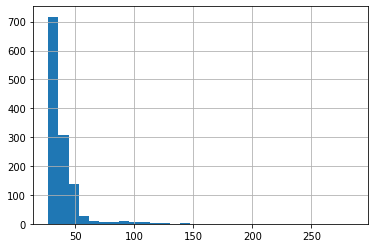

In [17]:
#compare lengths of trajectories and breadcrumbs - these should be roughly similar
lens = []
for tl in timelines:
    for t in tl:
        if t['type'] == "GridNavBreadcrumbs" and t['trialparams']['roundtype'] == 'main':
            lens.append(len(t['trialparams']['breadCrumbs'])*2 - 1)
lens = sorted(lens)
pd.Series(lens).hist(bins=30)

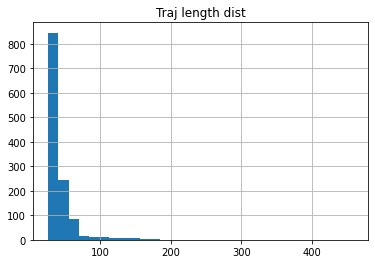

In [18]:
tlens = sum([[len(r['navparams']['traj']) for r in resp['rounds']] for resp in exp3_resp], [])
tlens = sorted(tlens)
_ = pd.Series(tlens).hist(bins=30).set_title("Traj length dist")

<AxesSubplot:>

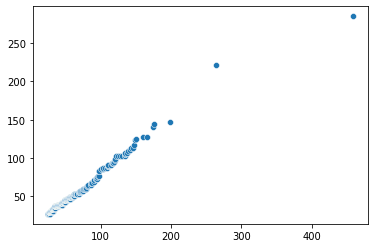

In [19]:
import seaborn as sns
sns.scatterplot(x=tlens, y=lens)

In [20]:
assert abs(np.median(tlens) -  np.median(lens)) < 1.5
assert len(tlens) == len(lens)

In [21]:
shape = lambda g: (len(g[0]), len(g))
N_MAIN_TRIALS = 8
GRID_SHAPE = (13, 13)
for tl in timelines:
    #test correct number of main trials
    assert len([t for t in tl if t.get('trialparams', False) and t['trialparams']['roundtype'] == 'main']) == N_MAIN_TRIALS
    #test all grids are the same size (including practice)
    assert set([shape(t['taskparams']['feature_array']) for t in tl if t.get('taskparams', False)]) == {GRID_SHAPE}

In [22]:
#check that transformations/untransformations work
n = 0
transforms = []
for tl in timelines:
    for t in tl:
        if t['type'] == "GridNavBreadcrumbs" and t['trialparams']['roundtype'] == 'main':
            transform = t['trialparams']['transform']
            transforms.append(transform)
            bg = basegrids[t['trialparams']['grid']]
            tg = t['taskparams']['feature_array']
            if transform != "base":
                assert tuple(bg) != tuple(tg)
            n += 1
            assert tuple(gridutils.transformations[transform](bg)) == tuple(tg)
            assert tuple(gridutils.untransformations[transform](tg)) == tuple(bg)
assert n == N_MAIN_TRIALS*len(exp3_resp)
assert len(set(transforms)) > 2

# SAVE EXPERIMENT CONFIGURATIONS

In [23]:
import configparser
import datetime

EXP_CONFIG_DIR = "../../experiment.psiturkapp/static/config/"
EXP_CONFIG_FILE = EXP_CONFIG_DIR+"config.json.zip"
PSITURKAPP_CONFIG = "../../experiment.psiturkapp/config.txt"

In [24]:
# UPDATE PSITURK APP
import zipfile
json.dump(experiment_config,
          open(f"config.json", "w"), separators=(',', ':'))
zipfile.ZipFile("config.json.zip", mode="w", compression=zipfile.ZIP_DEFLATED).write("config.json")

config = configparser.ConfigParser()
res = config.read(PSITURKAPP_CONFIG)
assert len(res) > 0
config["Task Parameters"]["experiment_code_version"] = EXPERIMENT_CODE_VERSION
config["Task Parameters"]["num_conds"] = str(len(experiment_config['timelines']))
print(f"{len(experiment_config['timelines'])} conditions")
with open(PSITURKAPP_CONFIG, 'w') as configfile:
    config.write(configfile)
    
import subprocess
process = subprocess.Popen(f"cp config.json.zip {EXP_CONFIG_FILE}".split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output, error)
process = subprocess.Popen(f"cp config.json.zip {EXP_CONFIG_DIR + '/config-' + EXPERIMENT_CODE_VERSION}.json.zip".split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output, error)

156 conditions
b'' None
b'' None
